# Image Editing with Diffusion Models
---
## Authors:
*   **Luca Conti** (1702084)
*   **Daniele sabatini** (1890300)
---
## Project aim and selected paper
This project is based on the implementation of the paper [**InstructPix2Pix: Learning to Follow Image Editing Instructions**](https://arxiv.org/abs/2211.09800).  

Our implementation is divided into three main parts:

1. **Fine-tuning LLM**  
   In the first part, we fine-tuned a LLM model to create a dataset containing original prompts, edit prompt and edited prompts thaht would later be used for the second component of the project.

2. **Image Generation with Stable Diffusion and ControlNet**  
   In the second part, we used the prompts generated in the first part to create pairs of images, where one was the edited version of the other (i.e., maintaining coherence between them).  
   For this, we employed **Stable Diffusion** together with **ControlNet**.  
   The generated images were then used to build the dataset required for the final part of the project.

3. **Fine-tuning InstructPix2Pix**  
   In the last part of the project, we used the dataset produced in the second part to fine-tune a Stable Diffusion model.

---
## Image Generation with Stable Diffusion and ControlNet
### Theoretical Background

[**Stable Diffusion**](https://openaccess.thecvf.com/content/CVPR2022/papers/Rombach_High-Resolution_Image_Synthesis_With_Latent_Diffusion_Models_CVPR_2022_paper.pdf) is a latent text-to-image diffusion model that generates high-quality images from natural language descriptions. In this work, it serves as the backbone for producing the source images in the dataset.

**ControlNet** extends diffusion models by incorporating additional conditioning inputs. In this study, Canny edge maps of the source images are used as guidance to control the generation process, enabling reliable and semantically consistent image edits. This approach avoids the computationally expensive process of manually replacing attention weights, as done in Prompt-to-Prompt methods.

**CLIP** (Contrastive Language–Image Pretraining) is a neural network trained to map text and images into a shared embedding space. It is used here to evaluate and filter generated images by computing:  
- Directional similarity between source and target images  
- Image-to-image similarity  
- Image-to-caption similarity

---

### Implementation details

To generate the original images, we used the Stable Diffusion model `runwayml/stable-diffusion-v1-5`.  

Image editing is guided by `lllyasviel/sd-controlnet-canny`, which uses the source image structure (Canny edges) along with the target prompt to produce controlled edits.  

All images are generated at a resolution of `HEIGHT = 512 x WIDTH = 512` using `STEPS = 40` diffusion steps. A fixed seed (`SEED1`) ensures reproducibility.

To evaluate the generated images and enable filtering, we used the CLIP model `openai/clip-vit-large-patch14` to measure semantic and visual similarity between images and text.


The `controlnet_best` function generates a source image with Stable Diffusion and then creates a target image using ControlNet guided by Canny edges. Key steps include:

1. Generate the source image (`image_sd`) from `src_prompt`.
2. Preprocess the image for ControlNet:

   * Convert to Canny edges.
   * Resize to target resolution.
3. Iterate over multiple `controlnet_conditioning_scale` values to generate candidate edited images.
4. Evaluate candidate images using:

   * CLIP directional similarity (`dir_sim`)
   * Image-to-image similarity (`img_img_sim`)
   * Image-to-caption similarity (`img_cap_sim`)
5. Filter images based on thresholds (`dir_sim >= 0.15`, `img_img_sim >= 0.65`, `img_cap_sim >= 0.2`).
6. Return the image with the highest directional similarity.


>**Notes:**  
[Prompt-to-Prompt](https://arxiv.org/abs/2208.01626) replaces *cross-attention* weights in the second generated image differently depending on the type of edit (e.g., word swap, adding a phrase, increasing or decreasing the weight of a word).  
[Brooks et al.](https://arxiv.org/abs/2211.09800), on the other hand, replaced *self-attention* weights of the second image during the first $p$ fraction of diffusion steps and applied the same attention weight replacement strategy for all edits. However, replacing self-attention weights is computationally expensive.  
Moreover, finding the optimal combination of parameters for the original Prompt-to-Prompt method requires extensive search for each image. For these reasons, we opted to use [ControlNet](https://arxiv.org/abs/2302.05543) (Canny) instead. The only parameter we performed a search over was `controlnet_conditioning_scale`.


---
### Limitations and reflections

* **Dependence on Pretrained Models:** The quality and diversity of the generated dataset are bounded by the pretrained model’s biases, i.e., if SD struggles with certain subjects or styles, the dataset will inherit those limitations.

* **Synthetic Data Bias**: Both original and edited images are synthetically generated, not real-world images. This can lead to a domain gap when fine-tuning InstructPix2Pix for real-world tasks, reducing generalization.

* **Prompt Quality and Variability**: The dataset depends heavily on the quality and specificity of the original and edited prompt (the latter are generated by a finetuned LLM).


* **ControlNet Conditioning Scale**: We iterated over a limited set of `controlnet_conditioning_scale` values and filter images based on similarity metrics. It would be better to have a larger choices of  `controlnet_conditioning_scale`. Also, Selecting thresholds (`dir_sim >= 0.15`, `img_img_sim >= 0.65`, `img_cap_sim >= 0.2`) is heuristic and may bias the dataset toward safe or easy edits, ignoring harder transformations.


* **Similarity Metrics Limitations**: We relied on CLIP-based directional similarity, image-image similarity, and image-caption similarity. CLIP may fail for subtle edits or abstract concepts, meaning some high-quality pairs could be discarded. Metrics are not perfect proxies for human perception; some images passing thresholds may still be semantically incorrect (and viceversa).

---
### References

* Amir Hertz, Ron Mokady, Jay Tenenbaum, Kfir Aberman, Yael Pritch, Daniel Cohen-Or.
  *Prompt-to-Prompt Image Editing with Cross Attention Control.*
  arXiv:2208.01626, 2022.
  [https://arxiv.org/abs/2208.01626](https://arxiv.org/abs/2208.01626)

* Tim Brooks, Aleksander Holynski, Alexei A. Efros.
  *InstructPix2Pix: Learning to Follow Image Editing Instructions.*
  arXiv:2211.09800, 2022.
  [https://arxiv.org/abs/2211.09800](https://arxiv.org/abs/2211.09800)

* Lvmin Zhang, Maneesh Agrawala.
  *Adding Conditional Control to Text-to-Image Diffusion Models.*
  arXiv:2302.05543, 2023.
  [https://arxiv.org/abs/2302.05543](https://arxiv.org/abs/2302.05543)

* Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer.  
  [*High-Resolution Image Synthesis with Latent Diffusion Models.*](https://openaccess.thecvf.com/content/CVPR2022/papers/Rombach_High-Resolution_Image_Synthesis_With_Latent_Diffusion_Models_CVPR_2022_paper.pdf)
  CVPR 2022.  

# Import

In [1]:
import os, math, difflib, inspect
from pathlib import Path
import torch
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from diffusers import ControlNetModel, StableDiffusionControlNetPipeline

from huggingface_hub import login
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.models.attention_processor import AttnProcessor
from difflib import SequenceMatcher

from transformers import CLIPProcessor, CLIPModel

import json

import shutil
from huggingface_hub import Repository

from datasets import load_dataset
from huggingface_hub import list_repo_files
import os

# GLOBALS

In [2]:
# Select the device: use GPU ("cuda") if available, otherwise fallback to CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Path where the dataset is stored locally
DATASET_PATH = "./dataset"

# Hugging Face model ID for Stable Diffusion v1.5
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
# Hugging Face model ID for the CLIP model (used for text-image similarity)
CLIP_MODEL_ID = "openai/clip-vit-large-patch14"
# Hugging Face model ID for ControlNet with Canny edges
CONTROLNET_MODEL_ID = "lllyasviel/sd-controlnet-canny"

# Image resolution (height in pixels)
HEIGHT = 512
# Image resolution (width in pixels)
WIDTH = 512
# First random seed for reproducibility
SEED1 = 20230330
# Second random seed for reproducibility or variability
SEED2 = 1000
# Flag to enable or disable printing debug information
PRINT_INFO = False
# Number of inference steps (diffusion steps)
STEPS = 40

# Flag to enable pushing results/models to the Hugging Face Hub
PUSH_TO_HUB = True
# Hugging Face authentication token
HF_TOKEN = "YOUR_HUGGING_FACE_TOKEN"

# HF username (from environment variable, or default if not set)
HF_USER = "YOUR_HUGGING_FACE_USERNAME"
# HF email (from environment variable, or default if not set)
HF_EMAIL = "YOUR_HUGGING_FACE_EMAIL"

# Hugging Face repository ID (namespace/repo_name)
REPO_ID =  "YOUR_HUGGING_FACE_REPO_NAME"
# Local path to clone or store the repository
local_repo_path = "PATH OF THE CLONED REPO"

# Path to the JSONL file containing paired captions for training/evaluation
PAIRED_CAPTIONS_PATH = "path of JSONL file containing paired captions"


In [3]:
print(HF_USER)
print(HF_EMAIL)

iamlucaconti
conti.1702084@studenti.uniroma1.it


In [4]:
os.environ["HF_TOKEN"] = HF_TOKEN
dtype = torch.float16 if DEVICE == "cuda" else torch.float32

# Cloning the REPO

In [5]:
# Define the paths for the input and edited image folders inside the dataset directory
INPUT_IMG_PATH  = os.path.join(DATASET_PATH, "input_images")
EDITED_IMG_PATH = os.path.join(DATASET_PATH, "edited_images")
METADATA_PATH = os.path.join(DATASET_PATH, "metadata.jsonl")

In [6]:

if PUSH_TO_HUB:
  METADATA_PATH = os.path.join(local_repo_path, "metadata.jsonl")
  INPUT_IMG_PATH  = os.path.join(local_repo_path, "input_images")
  EDITED_IMG_PATH = os.path.join(local_repo_path, "edited_images")

  !git lfs install
  !git clone https://huggingface.co/datasets/{REPO_ID}

  os.makedirs(INPUT_IMG_PATH, exist_ok=True)
  os.makedirs(EDITED_IMG_PATH, exist_ok=True)

else:
  os.makedirs(INPUT_IMG_PATH, exist_ok=True)
  os.makedirs(EDITED_IMG_PATH, exist_ok=True)

Git LFS initialized.
Cloning into 'instructpix2pix-controlnet'...
remote: Enumerating objects: 3435, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3435 (delta 5), reused 0 (delta 0), pack-reused 3423 (from 1)
Receiving objects: 100% (3435/3435), 747.20 KiB | 1.14 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Filtering content: 100% (2436/2436), 1.03 GiB | 52.60 MiB/s, done.


In [7]:
metadata = []
# If metadata.jsonl exists, load it as a list of dictionaries
if os.path.exists(METADATA_PATH) and os.path.isfile(METADATA_PATH):
    with open(METADATA_PATH, "r", encoding="utf-8") as f:
        for line in f:
            try:
                # Parse each line as a JSON object and append to the metadata list
                item = json.loads(line)
                metadata.append(item)
            except json.JSONDecodeError:
                # Ignore lines that are not valid JSON
                pass

print(f"The dataset has {len(metadata)} rows.")

The dataset has 1001 rows.


In [8]:
# Check the files inside input_images and find the maximum number in their filenames
current_idx = 0
if os.path.exists(INPUT_IMG_PATH) and os.path.isdir(INPUT_IMG_PATH):
    files = [f for f in os.listdir(INPUT_IMG_PATH) if f.endswith(".png")]
    if files:
        nums = []
        for f in files:
            base = os.path.splitext(f)[0]
            try:
                num = int(base)  # Convert the filename (without extension) to an integer
                nums.append(num)
            except ValueError:
                # Ignore files whose names are not numeric
                pass
        if nums:
            current_idx = max(nums)  # Get the maximum numeric value


# Print results
print(f"Current idx in the HF dataset: {current_idx}")
idx = current_idx + 1

Current idx in the HF dataset: 1631


# Models

## Stable diffusion

In [9]:
sd_t2i = StableDiffusionPipeline.from_pretrained(
    SD_MODEL_ID,
    torch_dtype=dtype,
    safety_checker=None,
).to(DEVICE)


sd_t2i.scheduler = DDIMScheduler.from_config(sd_t2i.scheduler.config)

# Ottimizzazioni (tolleranti: se non disponibili, ignora)
try:
    sd_t2i.enable_xformers_memory_efficient_attention()
except Exception:
    pass
sd_t2i.enable_attention_slicing("max")
sd_t2i.enable_vae_slicing()

tokenizer = sd_t2i.tokenizer  # CLIP tokenizer dal pipeline

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


## ControlNet

In [10]:
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL_ID, torch_dtype=dtype
).to(DEVICE)

pipe_controlnet = StableDiffusionControlNetPipeline.from_pretrained(
    SD_MODEL_ID,
    controlnet=controlnet,
    torch_dtype=dtype,
    safety_checker=None
).to(DEVICE)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [11]:
PRINT_INFO = False

if PRINT_INFO:
    sd_t2i.set_progress_bar_config(disable=False)
    pipe_controlnet.set_progress_bar_config(disable=False)
else:
    sd_t2i.set_progress_bar_config(disable=True)
    pipe_controlnet.set_progress_bar_config(disable=True)

## CLIP Model

In [12]:
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID,  use_fast=True)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Functions

## CLIP

In [13]:
@torch.no_grad()
def clip_text_embed(text):
    # Tokenize the input text and move tensors to the selected device
    inputs = clip_processor.tokenizer([text], return_tensors="pt", padding=True).to(DEVICE)
    # Extract the CLIP text embedding
    out = clip_model.get_text_features(**inputs)
    return out[0]  # Return the embedding vector for the first (and only) text


@torch.no_grad()
def clip_image_embed(image):
    # Preprocess the image and move tensors to the selected device
    inputs = clip_processor.image_processor(image, return_tensors="pt").to(DEVICE)
    # Extract the CLIP image embedding
    out = clip_model.get_image_features(**inputs)
    return out[0]  # Return the embedding vector for the image


@torch.no_grad()
def clip_embed(image, text):
    # Preprocess image and text separately
    img_inputs = clip_processor.image_processor(image, return_tensors="pt").to(DEVICE)
    txt_inputs = clip_processor.tokenizer([text], return_tensors="pt", padding=True).to(DEVICE)
    # Extract image and text embeddings
    img_emb = clip_model.get_image_features(**img_inputs)[0]
    txt_emb = clip_model.get_text_features(**txt_inputs)[0]
    return img_emb, txt_emb  # Return both embeddings


@torch.no_grad()
def clip_directional_similarity(img1, img2, txt1, txt2, eps=1e-6):
    # Get embeddings for both images and texts
    im1 = clip_image_embed(img1)
    im2 = clip_image_embed(img2)
    t1 = clip_text_embed(txt1)
    t2 = clip_text_embed(txt2)

    # Compute "direction" vectors: change from img1→img2 and from txt1→txt2
    dir_img = im2 - im1
    dir_txt = t2 - t1

    # Compute norms to avoid division by zero
    norm_dir_img = dir_img.norm()
    norm_dir_txt = dir_txt.norm()

    # If any direction vector is too small, return 0 similarity
    if norm_dir_img < eps or norm_dir_txt < eps:
        return 0.0

    # Normalize both direction vectors
    dir_img = dir_img / norm_dir_img
    dir_txt = dir_txt / norm_dir_txt

    # Return cosine similarity between image direction and text direction
    return torch.nn.functional.cosine_similarity(dir_img.unsqueeze(0), dir_txt.unsqueeze(0)).item()


@torch.no_grad()
def clip_image_similarity(img1, img2):
    # Get normalized image embeddings
    im1 = clip_image_embed(img1)
    im2 = clip_image_embed(img2)
    im1 = im1 / im1.norm()
    im2 = im2 / im2.norm()
    # Compute cosine similarity between the two images
    return torch.nn.functional.cosine_similarity(im1.unsqueeze(0), im2.unsqueeze(0)).item()


@torch.no_grad()
def clip_image_caption_similarity(image, caption):
    # Get normalized embeddings for image and caption
    im_feat = clip_image_embed(image)
    txt_feat = clip_text_embed(caption)
    im_feat = im_feat / im_feat.norm()
    txt_feat = txt_feat / txt_feat.norm()
    # Compute cosine similarity between image and text
    return torch.nn.functional.cosine_similarity(im_feat.unsqueeze(0), txt_feat.unsqueeze(0)).item()


In [14]:
def evaluate_pair(before, after, original_prompt, output_prompt, print_info=False):
    # Compute CLIP-based metrics
    dir_sim = clip_directional_similarity(before, after, original_prompt, output_prompt)
    img_sim = clip_image_similarity(before, after)
    img_caption_sim_before = clip_image_caption_similarity(before, original_prompt)
    img_caption_sim_after  = clip_image_caption_similarity(after, output_prompt)

    # Print results
    print(f"[CLIP] Directional similarity:             {dir_sim:.4f}")
    print(f"[CLIP] Image similarity:                   {img_sim:.4f}")
    print(f"[CLIP] Image-caption similarity (before):  {img_caption_sim_before:.4f}")
    print(f"[CLIP] Image-caption similarity (after):   {img_caption_sim_after:.4f}")

    if print_info:
        # Check against quality criteria
        passed = True
        if img_sim < 0.75:
            print("Image-image similarity too low (< 0.75)")
            passed = False
        if dir_sim < 0.20:
            print("Directional similarity too low (< 0.20)")
            passed = False
        if img_caption_sim_before < 0.20:
            print("Image-caption similarity (before) too low (< 0.20)")
            passed = False
        if img_caption_sim_after < 0.20:
            print("Image-caption similarity (after) too low (< 0.20)")
            passed = False

        if passed:
            print("All CLIP criteria met!")

    return dir_sim, img_sim, img_caption_sim_before, img_caption_sim_after


In [15]:
def show_pair(img1, img2, original_prompt, edited_prompt):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img1); plt.title(original_prompt); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img2); plt.title(edited_prompt); plt.axis("off")
    plt.show()

# ControlNet

## Single image

Without ControlNet


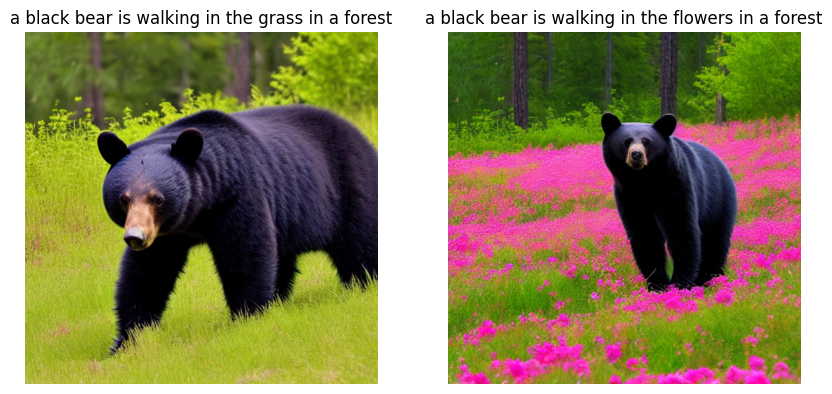

[CLIP] Directional similarity:             0.2273
[CLIP] Image similarity:                   0.8839
[CLIP] Image-caption similarity (before):  0.2784
[CLIP] Image-caption similarity (after):   0.3459

With ControlNet


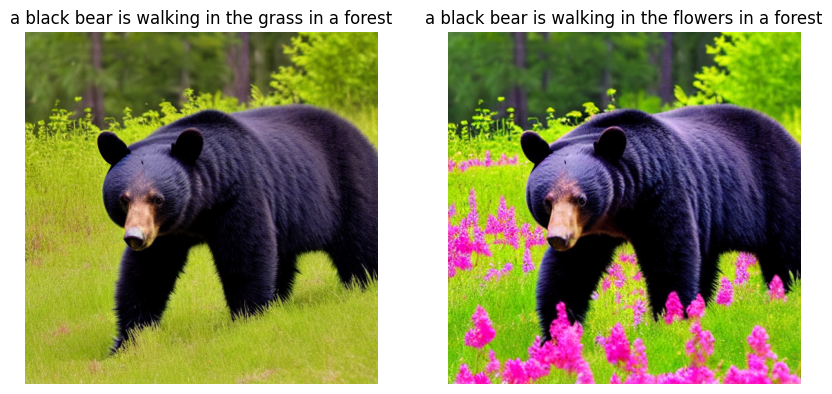

[CLIP] Directional similarity:             0.2636
[CLIP] Image similarity:                   0.9150
[CLIP] Image-caption similarity (before):  0.2784
[CLIP] Image-caption similarity (after):   0.3244


In [16]:
prompt  = "a black bear is walking in the grass in a forest"
edited_prompt  =  "a black bear is walking in the flowers in a forest"

seed = SEED1
steps = 40

# Generation of teh original image
generator = torch.Generator(DEVICE).manual_seed(seed)
image_sd = sd_t2i(prompt, num_inference_steps=steps, generator=generator).images[0]

# Without ControlNet
generator_no_cn = torch.Generator(DEVICE).manual_seed(seed)
image_sd_no_cn = sd_t2i(edited_prompt, num_inference_steps=steps, generator=generator_no_cn).images[0]
print("Without ControlNet")
show_pair(image_sd, image_sd_no_cn, prompt, edited_prompt)
dir_sim, img_sim, img_caption_sim_before, img_caption_sim_after = evaluate_pair(
    image_sd,
    image_sd_no_cn,
    prompt,
    edited_prompt,
    print_info=False)


# === Prepara immagine per ControlNet ===
image = np.array(image_sd)
image = cv2.Canny(image, 100, 200)
image = Image.fromarray(image).convert("RGB")

scale = 0.15

# === Genera immagine con ControlNet ===
generator_controlnet = torch.Generator(DEVICE).manual_seed(seed)
image_controlnet = pipe_controlnet(
    edited_prompt,
    image,
    num_inference_steps=steps,
    generator=generator_controlnet,
    controlnet_conditioning_scale= scale
).images[0]

print("\nWith ControlNet")
show_pair(image_sd, image_controlnet, prompt, edited_prompt)

dir_sim, img_sim, img_caption_sim_before, img_caption_sim_after = evaluate_pair(
    image_sd,
    image_controlnet,
    prompt,
    edited_prompt,
    print_info=False)

## Creation of the dataset

In [17]:
@torch.no_grad()
def controlnet_best(pipe_sd,
                    pipe_controlnet,
                    src_prompt,
                    tgt_prompt,
                    seed=20230330,
                    steps=50,
                    width=512, height=512,
                    print_info=False):

    generator = torch.Generator(DEVICE).manual_seed(seed)

    image_sd = pipe_sd(
        src_prompt,
        width=width,
        height=height,
        num_inference_steps=steps,
        generator=generator,
        safety_checker=None
    ).images[0]

    # === Prepara immagine per ControlNet ===
    img_src = np.array(image_sd)
    img_src = cv2.Canny(img_src, 100, 200)
    img_src = Image.fromarray(img_src).convert("RGB")
    img_src = img_src.resize((width, height))

    scales = [0.15, 0.18, 0.2, 0.25, 0.3]
    # scales = [0.15]

    saved = []
    for i, scale in enumerate(scales):
        generator_controlnet = torch.Generator(DEVICE).manual_seed(seed)
        img_tgt = pipe_controlnet(
            tgt_prompt,
            img_src,
            width=width,
            height=height,
            num_inference_steps=steps,
            generator=generator_controlnet,
            controlnet_conditioning_scale=scale
        ).images[0]

        dir_sim = clip_directional_similarity(image_sd, img_tgt, src_prompt, tgt_prompt)
        img_img_sim = clip_image_similarity(image_sd, img_tgt)
        img_cap_sim = clip_image_caption_similarity(img_tgt, tgt_prompt)

        if print_info:
            print(f"[{i+1}] Conditioning scale: {scale} |")
            print(f"[{i+1}] dir_sim={dir_sim:.3f} | img-img={img_img_sim:.3f} | img-cap={img_cap_sim:.3f}")
            # show_pair(image_sd, img_tgt, src_prompt, tgt_prompt)
        if dir_sim >= 0.15 and img_img_sim >= 0.65 and img_cap_sim >= 0.2:
            if print_info:
                print("All test passed!")
            saved.append((dir_sim, img_tgt))

    if not saved:
        if print_info:
            print("No image passed the test.")
        return image_sd, None

    # Ordina per similarità direzionale
    saved.sort(key=lambda x: x[0], reverse=True)

    _, selected_image = saved[0]
    return image_sd, selected_image


In [18]:
def update_metadata(metadata, original_prompt, edit_prompt, edited_prompt, filename):

    input_img_path = os.path.join("input_images", filename)
    edited_img_path = os.path.join("edited_images", filename)

    dict_meta = {
        "original_prompt" : original_prompt,
        "original_image_file_name" : input_img_path,
        "edit_prompt" : edit_prompt,
        "edited_prompt" : edited_prompt,
        "edited_image_file_name" : edited_img_path
    }
    metadata.append(dict_meta)

In [19]:
def single_seed_update(
    metadata,
    src_prompt,
    tgt_prompt,
    idx=1,
    pipe_sd=sd_t2i,
    pipe_controlnet=pipe_controlnet,
    seed = SEED1,
    steps = STEPS,
    print_info = PRINT_INFO,
    height = HEIGHT, width = WIDTH,
):

    before, after = controlnet_best(
        pipe_sd=sd_t2i,
        pipe_controlnet=pipe_controlnet,
        src_prompt=original_prompt,
        tgt_prompt=edited_prompt,
        seed = seed,
        steps = STEPS,
        print_info = PRINT_INFO,
        height = HEIGHT, width = WIDTH
    )


    if after is not None:
        # show_pair(before, after, original_prompt, edited_prompt)
        filename = f"{idx:05d}.png"
        input_img_path = os.path.join(INPUT_IMG_PATH, filename)
        edited_img_path = os.path.join(EDITED_IMG_PATH, filename)

        before.save(input_img_path)
        after.save(edited_img_path)

        update_metadata(metadata, original_prompt, edit_prompt, edited_prompt, filename)

        idx += 1

    return idx

In [20]:
idx

1632

In [21]:
def check_prompts_in_metadata(metadata, original_prompt, edited_prompt, edit_prompt):
    for i, d in enumerate(metadata):
        if (d.get("original_prompt") == original_prompt and
            d.get("edited_prompt") == edited_prompt):
            # print(f"\n Already processed paired captions. Skipping...")
            return False

    # print("\n No match found... ")
    return True


# SE HAI GIA AVVIATO UNA VOLTA E NON HAI STACCATO IL RUNTIME, RUNNA DA QUI

In [29]:
data_list = []
with open(PAIRED_CAPTIONS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        data_list.append(json.loads(line.strip()))

# print(len(data_list))

data_list = data_list[:1000]  # TODO: modify here if you want to process only a subset of the caption pairs
print("Caption pair to be processed: ", len(data_list))


Caption pair to be processed:  1000


In [32]:
print("Starting from idx ", idx)

Starting from idx  1632


In [ ]:
from tqdm import tqdm

seed_list = [SEED1]

for pair in tqdm(data_list, desc="Processing caption pairs"):
  original_prompt = pair["original_prompt"]
  edited_prompt =  pair["edited_prompt"]
  edit_prompt =  pair["edit_prompt"]

  not_in_dataset =  check_prompts_in_metadata(metadata, original_prompt, edited_prompt, edit_prompt)


  if not_in_dataset:
      # print("Current idx: ", idx)
      for seed in seed_list:

          idx = single_seed_update(pipe_sd=sd_t2i,
              pipe_controlnet=pipe_controlnet,
              src_prompt=original_prompt,
              tgt_prompt=edited_prompt,
              seed = seed,
              steps = STEPS,
              print_info = PRINT_INFO,
              height = HEIGHT, width = WIDTH,
              metadata=metadata,
              idx=idx
          )
          # print("Current idx: ", idx)


In [ ]:
idx

# Pushing on Hugging Face

In [26]:
if PUSH_TO_HUB:
    with open(METADATA_PATH, "w", encoding="utf-8") as f:
        for item in metadata:
            json.dump(item, f)
            f.write("\n")

In [ ]:
if PUSH_TO_HUB:

    with open(os.path.expanduser("~/.netrc"), "w") as f:
        f.write(f"machine huggingface.co\nlogin hf\npassword {HF_TOKEN}\n")
    os.system("chmod 600 ~/.netrc")

    %cd instructpix2pix-controlnet
    # Configura il remote origin con il token (https)
    !git remote set-url origin https://huggingface.co/datasets/{REPO_ID}

    # Configura le credenziali Git per usare il token
    !git config --global user.email "{HF_EMAIL}"
    !git config --global user.name "{HF_USER}"

    # Aggiungi, committa e pusha le modifiche
    !git add .
    !git commit -m "New images."
    !git push

    %cd ..